# Summary

I can use PyMC3 to estimate the posterior PDF for the true skill level of every BUDA team using its W-L record during the season. This could be superior to my initial approach of assuming a discrete skill level based on Division and then modifying that skill level based on individual game outcomes. It will also serve as a great playground in which to explore PyMC3. 

Before I jump in with actual BUDA data, I want to test things out with a small sample of artificial game data.

In [1]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
from pymc3.math import invlogit

%matplotlib inline

In [11]:
n_teams = 4
teams = range(n_teams)

In [12]:
true_skill = {}
for team in teams:
    true_skill[team] = np.random.normal(loc=1600, scale=200)

In [13]:
true_skill

{0: 1867.5542224486926,
 1: 1462.443571383618,
 2: 1758.5549428218774,
 3: 1431.482710466947}

In [14]:
n_games = 20 * n_teams
games = range(n_games)
database = []
for game in games:
    game_database = {}
    matchup = np.random.choice(teams, size=2, replace=False)
    game_database['Team A'] = matchup[0]
    game_database['Team B'] = matchup[1]
    
    true_skills = [true_skill[matchup[0]], true_skill[matchup[1]]]
    game_skills = np.random.normal(loc=true_skills, scale=100)
    
    outcome_A = game_skills[0] > game_skills[1]
    game_database['Winner is A'] = outcome_A
    
    database.append(game_database)
    

In [15]:
game_results = pd.DataFrame(database)

In [16]:
game_results.head(10)

,Team A,Team B,Winner is A
0,1,2,False
1,0,1,True
2,3,1,False
3,1,0,False
4,3,2,False
5,2,0,False
6,2,1,True
7,0,2,True
8,2,0,False
9,1,0,False


Prior on each team is a normal distribution with mean of 1600 and standard deviation of 200.

In [17]:
with pm.Model() as model:
    skill = pm.Normal('skill', mu=1600, sd=200, shape=n_teams)
    scale = pm.HalfNormal('scale', sd=100)

    A_minus_B = []
    for row in game_results.index:
        team_A = game_results.loc[row, 'Team A']
        team_B = game_results.loc[row, 'Team B']
        A_minus_B.append(skill[team_A] - skill[team_B])
    
    probability_A_beats_B = pm.math.invlogit(1 / scale * A_minus_B)
    
    observation = pm.Bernoulli('observation', probability_A_beats_B, observed=game_results['Winner is A'].values)

INFO (theano.gof.compilelock): Refreshing lock /Users/rbussman/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock


In [18]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -37.039: 100%|██████████| 200000/200000 [01:03<00:00, 3163.91it/s]
Finished [100%]: Average ELBO = -36.656
INFO (theano.gof.compilelock): Refreshing lock /Users/rbussman/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125f08e50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126041d90>]], dtype=object)

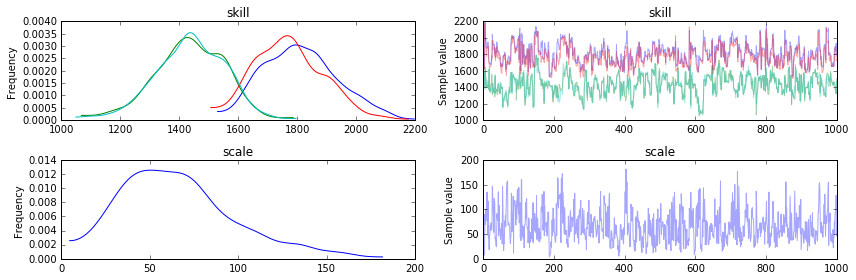

In [19]:
pm.traceplot(trace)